# 6 Chemistry
The aim of this exercise is to understand how chemical networks work, to play with a network that describes the formation of water, and then to extend it to include also carbon monoxide.

The Python procedures provided integrate a reduced chemical network for $H_2 O$ for a period of $10^7$ yr. At its core is an ODE solver (`solve_ivp` from `scipy.integrate`) that evolves the system for a given time step (`time_step`) and initial conditions (`number_density`). The initial conditions are $n_{H_2} = 10^7$ cm$^{−3}$ and $n_O=10^4$ cm$^{−3}$ . We are assuming a partially molecular gas and a reservoir of $H_2$ which is only aﬀected by this network. All other species are initially set to a default minimum value of $10^{−40}$ cm$^{−3}$. The temperature is set to 50 K and remains constant since processes like cooling and heating are not included.

Three functions do the work: (i) the main one, `differential_equations()`, returns an array $d n_i/dt$ of size $N_s$ (`N_species`), which represents the system of ODEs. This function requires the (ii) `reaction rates()` function, which returns $N_r$ rates, using rate coefficients are provided by (iii) the function `rate_coefficients()`. 

### Libraries

In [347]:
import numpy as np
import matplotlib.pyplot as plt
import time as tm

# Use scipy package odeint to integrate the chemical network
from scipy.integrate import solve_ivp

### Dictionary mapping element names to indices

In [348]:
i = {'O+':0,'H2':1 ,'OH+':2, 'H':3, 'H2O+':4 , 'H3O+':5, 'E':6, 'H2O':7 , 'OH':8, 'O':9}
N_species = len(i)

### Initial values

In [349]:
number_density = np.zeros(N_species)
n_H2 = 1e7
number_density[:      ] = 1e-40
number_density[i['H2']] = n_H2
number_density[i['O' ]] = 1e-3*n_H2
Tgas = 50.0                             # Temperature [K], passed as global value
ionizing_cosmic_ray_flux = 1.3e-17      # Ionisation rate per atom [1/s]

### Reaction rate coefficients
We use a Python dictionary to name the rate coefficient as a string corresponding to the actual reaction. This autodocuments the network

In [350]:
def rate_coefficients():
    invsqrt = 1e0/np.sqrt(Tgas/3e2)
    k = {}
    k['O+   + H2 -> OH+  + H' ] = 1.6e-9
    k['OH+  + H2 -> H2O+ + H' ] = 1.1e-9
    k['H2O+ + H2 -> H3O+ + H' ] = 6.1e-10 
    k['H3O+ + E  -> H2O  + H' ] = 1.1e-7*invsqrt 
    k['H2O+ + E  -> OH   + H' ] = 8.6e-8*invsqrt
    k['H2O+ + E  -> O    + H2'] = 3.9e-8*invsqrt
    k['OH+  + E  -> O    + H' ] = 6.3e-9*(Tgas/3e2)**(-.48)
    k['O    + CR -> O+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux
    return k
k=rate_coefficients()
k

{'O+   + H2 -> OH+  + H': 1.6e-09,
 'OH+  + H2 -> H2O+ + H': 1.1e-09,
 'H2O+ + H2 -> H3O+ + H': 6.1e-10,
 'H3O+ + E  -> H2O  + H': 2.694438717061496e-07,
 'H2O+ + E  -> OH   + H': 2.106561178793533e-07,
 'H2O+ + E  -> O    + H2': 9.553009996854394e-08,
 'OH+  + E  -> O    + H': 1.4888575570590416e-08,
 'O    + CR -> O+   + E': 3.64e-17}

In [351]:
print('We have',len(k),'rate coefficients')

We have 8 rate coefficients


#### __Task 1: Draw the reaction network!__ (20p)
Draw a "reaction diagram" that includes the 10 species and 8 reactions above, using either paper and pen (use you smartphone to make an image to include), or your favorite drawing program (could be for example [Google drawings](https://docs.google.com/drawings/d/1MvuvqSulDURhXanJCtCJNlc0xqKIa3NzAl6YqNTXWjc/edit), or PowerPoint, OpenOffice, Inkscape, or whatever).  Here's an example of one way to draw such a diagram, where we integrate *simple* species ($e^-$, $H$, $H_2$ etc) in to the arrows:

<img src="./reactions.png" style="width:300px;"/>

I have drawn the reaction network where H2, H, and E as "enablers"/"catalysts". Here we easily see which reaction have no drain and thus will either accumulate or stay constant at any time.

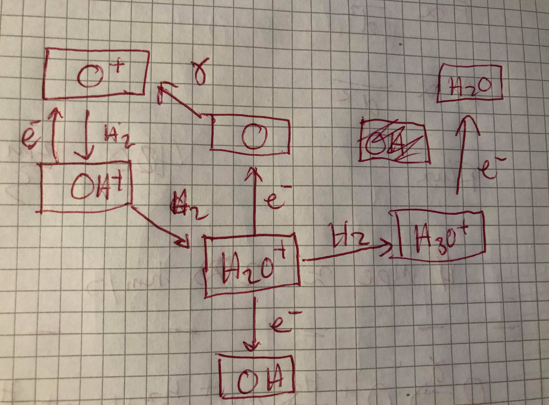


### Reaction rates
The individual reaction rates can now easily be calculated

In [352]:
def reaction_rates(n):
    k = rate_coefficients()
    return  [k['O+   + H2 -> OH+  + H' ] * n[i['O+'  ]] * n[i['H2']], # 0
             k['OH+  + H2 -> H2O+ + H' ] * n[i['OH+' ]] * n[i['H2']], # 1
             k['H2O+ + H2 -> H3O+ + H' ] * n[i['H2O+']] * n[i['H2']], # 2
             k['H3O+ + E  -> H2O  + H' ] * n[i['H3O+']] * n[i['E' ]], # 3
             k['H2O+ + E  -> OH   + H' ] * n[i['H2O+']] * n[i['E' ]], # 4
             k['H2O+ + E  -> O    + H2'] * n[i['H2O+']] * n[i['E' ]], # 5
             k['OH+  + E  -> O    + H' ] * n[i['OH+' ]] * n[i['E' ]], # 6
             k['O    + CR -> O+   + E' ] * n[i['O'   ]]]              # 7
reaction_rates(number_density)

[1.6e-42,
 1.0999999999999997e-42,
 6.0999999999999996e-43,
 2.694438717061495e-87,
 2.1065611787935326e-87,
 9.553009996854392e-88,
 1.4888575570590414e-88,
 3.6399999999999996e-13]

### Differential equations
Given the above set of reaction rates, we can constrcut our differential equations for each species by inspection. Triple check when adding new; it is very easy to get wrong! Notice that for reactions where there are as many reactants as products, the lines have to sum to zero, while externally induced reactions by e.g. photos or CRs do not sum to zero.

In [353]:
def differential_equations(t,n):
    r = reaction_rates(n)
    dn = np.zeros(N_species)
    dn[i['O+'  ]] = -r[0]                              +r[7]
    dn[i['H2'  ]] = -r[0]-r[1]-r[2]          +r[5]
    dn[i['OH+' ]] = +r[0]-r[1]                    -r[6]
    dn[i['H'   ]] = +r[0]+r[1]+r[2]+r[3]+r[4]     +r[6]
    dn[i['H2O+']] =      +r[1]-r[2]     -r[4]-r[5]
    dn[i['H3O+']] =           +r[2]-r[3]
    dn[i['E'   ]] =                -r[3]-r[4]-r[5]-r[6]+r[7]
    dn[i['H2O' ]] =                +r[3]
    dn[i['OH'  ]] =                     +r[4]
    dn[i['O'   ]] =                          +r[5]+r[6]-r[7]
    return dn
differential_equations(0.0, number_density)

array([ 3.64000000e-13, -3.31000000e-42,  5.00000000e-43,  3.31000000e-42,
        4.90000000e-43,  6.10000000e-43,  3.64000000e-13,  2.69443872e-87,
        2.10656118e-87, -3.64000000e-13])

### Solution
To evolve these ordinary differential eqations (ODEs), we use the `solve_ivp` method from `scipy.integrate`.  Since we want to track the time evolution, we construct a time_grid with a timestep increasing by 5% each time (while avoiding to increase the time step to more than a million year since this tends to challenge the `solve_ivp` beyond what it can handle with the given network), and then call the solver.

*ramping up* the integration of the chemical network is standard practice. Often the initial condition will be far from equilibrium, and by slowly increasing the spacing between solution points we can catch reactions happening at different reaction velocities (e.g. it is related to the relative stiffness of the network).

Below we use a very low ```atol``` to make sure that even species with a number density of 1e-40 are properly tracked.

In [354]:
def solution(diff_eqs, yrs=1e7, max_step=1e6, method='LSODA', rtol=1e-6, atol=1e-40):
    spy = 365e0*24e0*3600e0        # seconds per year
    time_step = np.copy(spy)       # initial time-step (s)
    time_end  = yrs*spy            # end of simulation (s)
    n = number_density

    start = tm.time()

    # time_grid is a geometrically increasing series with a max spacing of "max_step" yrs
    time_grid = []
    time      = 0.1 * time_step   # initial time output > 0 to avoid species having 1e-40 number density
    while time < time_end:
        time_grid.append(time)
        time += time_step
        time_step = min(time_step * 1.05, max_step*spy) #one can change this for better resolution if needed

    time_grid = np.array(time_grid)

    # Make sure we are charge neutral. Compute electrons number density (sum over ions)
    n[i['E']] = n[i['O+']] + n[i['OH+']] + n[i['H2O+']] + n[i['H3O+']]

    # Solve the differential equations defined in "diff_eqs" over the interval "(0,time_end)"
    # with input values "n" storing the solution at times "time_grid" using the ODE solver
    # method "method" (LSODA) with relative and absolute tolerances "rtol", "atol".
    solution = solve_ivp(diff_eqs, (0, time_end), n, t_eval=time_grid, \
                         method=method, rtol=rtol, atol=atol)
    print('time used: {:.2f} sec'.format(tm.time()-start))

    # return solution times in units of yr and number densities for each time in time_grid.
    return solution.t/spy, solution.y

yr,n = solution(differential_equations)

time used: 0.05 sec


### Plot results
Make a small routine that uses dictionary info to automatically plot all info about the species in the network as a function of time. To make the electron density (E) stand out, it is plotted with a stipled line stype.

time used: 0.05 sec


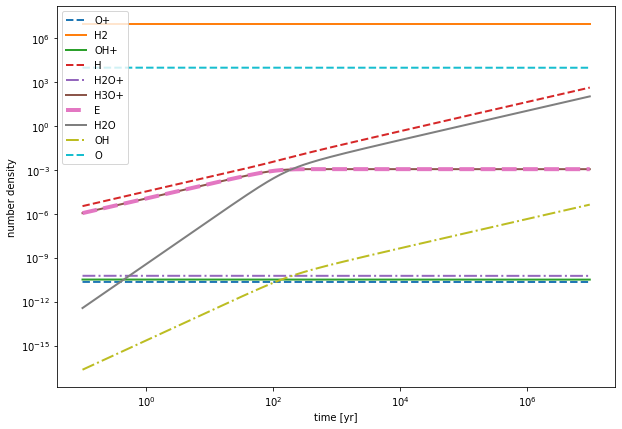

In [355]:
def plot(result,first=0,last=N_species,linewidth=2,mark=None):
    yr = result[0]
    n = result[1]
    names = list(i.keys())
    plt.figure(figsize=(10,7))
    for j in range(first,last):
        if names[j]=='E':
            plt.loglog(yr,n[j],'--',label=names[j],linewidth=linewidth*2)
        elif names[j]==mark:
            plt.loglog(yr,n[j],'-+',label=names[j],linewidth=linewidth)
        else:
            if j%3==0:
                plt.loglog(yr,n[j],label=names[j],linewidth=linewidth, linestyle='dashed')
            elif j%4==0:
                plt.loglog(yr,n[j],label=names[j],linewidth=linewidth, linestyle='dashdot')
            else:
                plt.loglog(yr,n[j],label=names[j],linewidth=linewidth)
    plt.xlabel('time [yr]')
    plt.ylabel('number density')
    plt.legend();

# set cosmic ray flux and recalculate network
ionizing_cosmic_ray_flux = 1.3e-17
result = solution(differential_equations)

plot(result)

### Utilities for printing equations and reactions rates 
First a routine ```eqnh``` that constructs a header line. The next prodocedure, ```eqnp``` prints a line, with blanks for rates that are not relevant, and red/black for important / unimportant rates (10% is the limit used -- you can change it of course)

In [356]:
def eqnh(r):
    """ Print a rate eqn header """
    nr = len(r)
    s = '  Eqn:      sum = '
    for j in range(nr):
        space = '    ' if j<10 else '   '
        s += space+'r[{:d}]'.format(j)
    s+= '  relative sum'        
    print(s)
    
def eqnp(label,select,dn,r, n=None):
    """ Print rates, with dominant ones in red """
    nr = len(r)
    red = '\x1b[31m'
    black = '\x1b[0m'
    rmax = 0.0
    for j in range(nr):
        if select[j] != 0:
            ra = np.abs(r[j])
            if ra > rmax:
                rmax = ra
    s = '{:>5}: {:8.1e} = '.format(label,dn[i[label]])
    for j in range(nr):
        ra = np.abs(r[j])
        color = red if ra > 0.1*rmax else black          
        if select[j]==0:
            s += '        '
        elif select[j]>0:
            s += '{}+{:7.1e}{}'.format(color,r[j],black)
        else:
            s += '{}-{:7.1e}{}'.format(color,r[j],black)
    if n[i[label]]!=None:
        s+= '  {:8.1e}'.format(dn[i[label]]/n[i[label]])
    print(s)

# for convenience, a small function to print out the network
def rpr(n):
    j = 0
    print('with the reaction rates:')
    for k in rate_coefficients().keys():
        s = 'r[{}]'.format(j)
        print('{:>22}: {}'.format(s,k))
        j += 1

This is where you arrange the actual printing, by entering 0 for rates that are not present, and +1 / -1 for positive and negative rates:

In [357]:
def print_rates(n,t=0.0):
    r = reaction_rates(n)
    eqnh(r)
    dn = np.zeros(N_species)
    print(np.shape(n))
    dn[i['O+'  ]] = -r[0]                              +r[7]
    eqnp('O+',    [ -1,   0,   0,   0,   0,   0,   0,  +1  ], dn, r, n)
    dn[i['H2'  ]] = -r[0]-r[1]-r[2]          +r[5] 
    eqnp('H2',    [ -1,  -1,  -1,   0,   0,  +1,   0,  0   ], dn, r, n)
    dn[i['OH+' ]] = +r[0]-r[1]                    -r[6]
    eqnp('OH+',   [ +1,  -1,   0,   0,   0,   0,  -1,  0   ], dn, r, n)
    dn[i['H'  ]] = +r[0]+r[1]+r[2]+r[3] +r[4]      +r[6]
    eqnp('H',    [ 1,  1,  1,   1,   1,  0,   1,  0   ], dn, r, n)
    dn[i['H2O+'  ]] =   +r[1] -r[2]         -r[4] -r[5] 
    eqnp('H2O+',    [ 0,  1,  -1,   0,   -1,  -1,   0,  0   ], dn, r, n)
    dn[i['H3O+'  ]] =   +r[2] -r[3] 
    eqnp('H3O+',    [ 0,  0,  1,   -1,   0,  0,   0,  0   ], dn, r, n)
    dn[i['E'   ]] =                -r[3]-r[4]-r[5]-r[6]+r[7] 
    eqnp('E',     [  0,   0,   0,  -1,  -1,  -1,  -1,  +1  ], dn, r, n)
    dn[i['H2O'  ]] =   +r[3] 
    eqnp('H2O',    [ 0, 0,  0,   1,   0,  0,   0,  0   ], dn, r, n)
    dn[i['OH' ]] = +r[4]
    eqnp('OH',   [ 0,  0,   0,   0,   1,   0,  0,  0   ], dn, r, n)
    dn[i['O' ]] = +r[5]+r[6]-r[7]
    eqnp('O',   [ 0,  0,   0,   0,   0,   1,  1,  -1   ], dn, r, n)
#     print('\nFILL IN THE REST OF THE NETWORK HERE!\n')
    rpr(n)
#remember to check the index
print_rates(n[:,-1])

  Eqn:      sum =     r[0]    r[1]    r[2]    r[3]    r[4]    r[5]    r[6]    r[7]  relative sum
(10,)
   O+: -3.3e-27 = -3.6e-13                                                +3.6e-13  -1.5e-16
   H2: -1.1e-12 = -3.6e-13-3.6e-13-3.6e-13                +6.5e-21                  -1.1e-19
  OH+: -1.3e-27 = +3.6e-13-3.6e-13                                -5.6e-22          -4.0e-17
    H:  1.4e-12 = +3.6e-13+3.6e-13+3.6e-13+3.6e-13+1.4e-20        +5.6e-22           3.3e-15
 H2O+: -2.0e-27 =         +3.6e-13-3.6e-13        -1.4e-20-6.5e-21                  -3.3e-17
 H3O+: -2.1e-20 =                 +3.6e-13-3.6e-13                                  -1.8e-17
    E: -2.1e-20 =                         -3.6e-13-1.4e-20-6.5e-21-5.6e-22+3.6e-13  -1.8e-17
  H2O:  3.6e-13 =                         +3.6e-13                                   3.3e-15
   OH:  1.4e-20 =                                 +1.4e-20                           3.3e-15
    O: -3.6e-13 =                                         +6

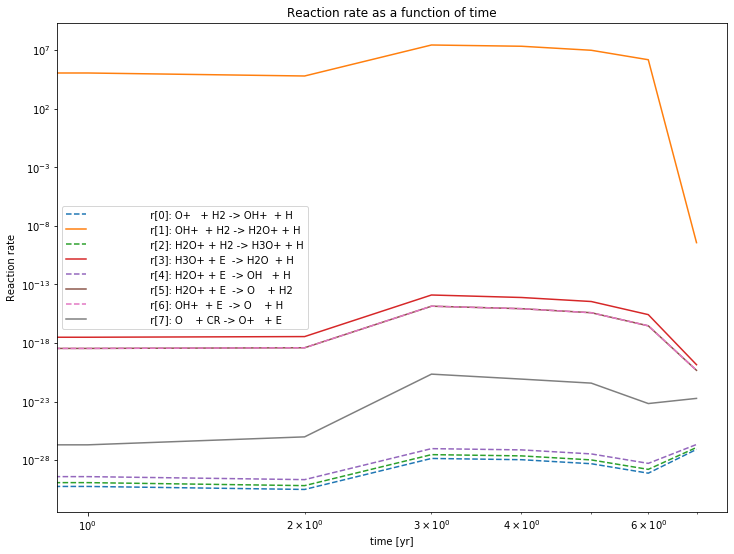

In [360]:
def rrate_plot(N=None):
    keys=list(rate_coefficients().keys())
    fig, ax=plt.subplots(figsize=(12,9))
    if N==None:
        N=len(keys)
    for j in range(N):
        s = 'r[{}]'.format(j)
        label='{:>22}: {}'.format(s,keys[j])
        if j%2==0:
            ax.loglog(reaction_rates(n[j,:]), label=label, linestyle='dashed')
        else:
            ax.loglog(reaction_rates(n[j,:]), label=label)
        ax.set(ylabel='Reaction rate', xlabel='time [yr]', title='Reaction rate as a function of time')
    ax.legend();
rrate_plot(N=8)

time used: 0.05 sec


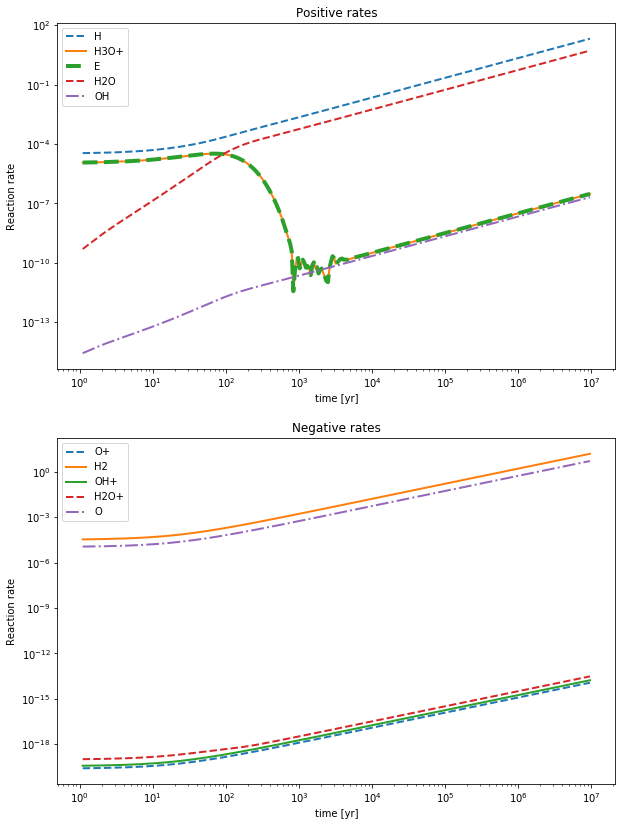

In [359]:
from itertools import compress
def plot_rates(result,first=0,last=N_species,linewidth=2,mark=None):
    yr = result[0]
    n = result[1]
    n = n-np.roll(n,1, axis=1)
    n1=np.abs(n[:, 1:])
    mask=n1[:,0]==n[:, 1:][:,0]
    pos=n1[mask]
    neg=n1[~mask]
    yr=yr[1:]
    #     print(np.shape(n), len(yr))
    name = list(i.keys())
    fig, ax=plt.subplots(2, figsize=(10,14))
    # print(np.shape(ax))
    n,names=pos, list(compress(name,mask))
    # print(np.shape(n), np.shape(names))
    for j in range(len(pos)):
        if names[j]=='E':
            ax[0].loglog(yr,n[j],'--',label=names[j],linewidth=linewidth*2)
    #     elif names[j]==mark:
    #         ax[0].loglog(yr,n[j],'-+',label=names[j],linewidth=linewidth)
        else:
            if j%3==0:
                ax[0].loglog(yr,n[j],label=names[j],linewidth=linewidth, linestyle='dashed')
            elif j%4==0:
                ax[0].loglog(yr,n[j],label=names[j],linewidth=linewidth, linestyle='dashdot')
            else:
                ax[0].loglog(yr,n[j],label=names[j],linewidth=linewidth)
    ax[0].set_xlabel('time [yr]')
    ax[0].set_ylabel('Reaction rate')
    ax[0].set_title('Positive rates')
    ax[0].legend()
    n,names=neg, list(compress(name,~mask))
    for j in range(len(neg)):
        if names[j]=='E':
            ax[1].loglog(yr,n[j],'--',label=names[j],linewidth=linewidth*2)
    #     elif names[j]==mark:
    #         ax[1].loglog(yr,n[j],'-+',label=names[j],linewidth=linewidth)
        else:
            if j%3==0:
                ax[1].loglog(yr,n[j],label=names[j],linewidth=linewidth, linestyle='dashed')
            elif j%4==0:
                ax[1].loglog(yr,n[j],label=names[j],linewidth=linewidth, linestyle='dashdot')
            else:
                ax[1].loglog(yr,n[j],label=names[j],linewidth=linewidth)
    ax[1].set_xlabel('time [yr]')
    ax[1].set_ylabel('Reaction rate')
    ax[1].set_title('Negative rates')
    ax[1].legend();
    
# set cosmic ray flux and recalculate network
ionizing_cosmic_ray_flux = 1.3e-17
result = solution(differential_equations)

plot_rates(result)

In [307]:
# result[1][4]
np.min(reaction_rates(n))

5.6554829502292005e-25

__HINT:__ Use the "Insert" button on your keyboard to switch from "insert" to "overwrite" (and back)!

#### __Task 2: Describe and discuss the evolution__ (20p)
   1. Some abundances change dramatically, while others (also some molecules) don't - why? 
   2. In particular, what is happening with hydrogen (H)?
   3. Some of the ones that change stop changing at some point in time - why? 

Discuss and explain, in terms of the reaction network and coefficients!  

First of all, there are some things that do not change that much, since their abundances are very high, and their reaction rates aren't high enough enough for them to change on the timescale we investigate here. For this first case I am specifically thinking about $H_2$ and $O$. The only reaction that removes $O$ is 7 and the cosmic ray ionization rate of 1.3e-17 is just not high enough to really make anything happen, as can be seen in my relative sum extension to Troels' function below.

Three types don't have an outlet, H, H2O, OH, so they then increase continuosly. They have the exact same relative growth rates in the end since all things they depend on are stable and their "equilibrium" is just stable growth.

H has no reaction that uses it, so it is continually produced. If we let this continue, we could reach a point where all hydrogen in the system is in atomic form. Note that all reaction rates are positive as can be seen in the above plot.

Looking at the reaction rates, we can see that the reaction chain essentially goes quickly through 7->0->1->2, which means that O+, OH+ and H2O+ are used almost as soon as they are produced, which we see as them being in equilibrium at a very low abundance throughout everything. This holds as long as H2 (the "catalysator" for 0,1,2) and O (for 7) abundances remain high. 3 is then a bottleneck since it is much slower than the former. Thus, E and H30+, the reactants in 3, are not used very quickly, and grow together. However, they eventually reach the same reaction rate as 0,1,2 and is thus a quick reaction and no longer a bottleneck. These two are now in equlibrium. Since these two keep growing, and these two together make H2O, the growth rate of H2O is higher than the equilibrium growth rate which we see later. 

E and H3O+ grow together, since H3O+ is by far the highest abundance atom, and our mixture is electrically neutral by construction.

At least, I want to make a remark on the notion than some of the abundances stop changing. They don't, simply just much slower than before as can be seen in the rate plot above.

In [308]:
print_rates(n[:,-1])

  Eqn:      sum =     r[0]    r[1]    r[2]    r[3]    r[4]    r[5]    r[6]    r[7]  relative sum
(10,)
   O+: -3.3e-27 = -3.6e-13                                                +3.6e-13  -1.5e-16
   H2: -1.1e-12 = -3.6e-13-3.6e-13-3.6e-13                +6.5e-21                  -1.1e-19
  OH+: -1.3e-27 = +3.6e-13-3.6e-13                                -5.6e-22          -4.0e-17
    H:  1.4e-12 = +3.6e-13+3.6e-13+3.6e-13+3.6e-13+1.4e-20        +5.6e-22           3.3e-15
 H2O+: -2.0e-27 =         +3.6e-13-3.6e-13        -1.4e-20-6.5e-21                  -3.3e-17
 H3O+: -2.1e-20 =                 +3.6e-13-3.6e-13                                  -1.8e-17
    E: -2.1e-20 =                         -3.6e-13-1.4e-20-6.5e-21-5.6e-22+3.6e-13  -1.8e-17
  H2O:  3.6e-13 =                         +3.6e-13                                   3.3e-15
   OH:  1.4e-20 =                                 +1.4e-20                           3.3e-15
    O: -3.6e-13 =                                         +6

In [309]:
r = reaction_rates(n[:,-1])
k, r

({'O+   + H2 -> OH+  + H': 1.6e-09,
  'OH+  + H2 -> H2O+ + H': 1.1e-09,
  'H2O+ + H2 -> H3O+ + H': 6.1e-10,
  'H3O+ + E  -> H2O  + H': 2.694438717061496e-07,
  'H2O+ + E  -> OH   + H': 2.106561178793533e-07,
  'H2O+ + E  -> O    + H2': 9.553009996854394e-08,
  'OH+  + E  -> O    + H': 1.4888575570590416e-08,
  'O    + CR -> O+   + E': 3.64e-17},
 [3.6003362639748277e-13,
  3.6003362583416414e-13,
  3.60033604943589e-13,
  3.600336259818329e-13,
  1.4372717059339472e-20,
  6.517860061793482e-21,
  5.633199400765394e-22,
  3.600336263974795e-13])

In [310]:
print_rates(n[:,0])

  Eqn:      sum =     r[0]    r[1]    r[2]    r[3]    r[4]    r[5]    r[6]    r[7]  relative sum
(10,)
   O+: -9.1e-28 = -3.6e-13                                                +3.6e-13  -4.0e-17
   H2: -1.1e-12 = -3.6e-13-3.6e-13-3.6e-13                +6.5e-24                  -1.1e-19
  OH+: -1.2e-27 = +3.6e-13-3.6e-13                                -5.7e-25          -3.5e-17
    H:  1.1e-12 = +3.6e-13+3.6e-13+3.6e-13+3.6e-19+1.4e-23        +5.7e-25           3.2e-07
 H2O+: -3.2e-27 =         +3.6e-13-3.6e-13        -1.4e-23-6.5e-24                  -5.4e-17
 H3O+:  3.6e-13 =                 +3.6e-13-3.6e-19                                   3.2e-07
    E:  3.6e-13 =                         -3.6e-19-1.4e-23-6.5e-24-5.7e-25+3.6e-13   3.2e-07
  H2O:  3.6e-19 =                         +3.6e-19                                   9.5e-07
   OH:  1.4e-23 =                                 +1.4e-23                           6.3e-07
    O: -3.6e-13 =                                         +6

#### __Task 3: Vary the cosmic ray flux__ (10p)
One of the reactions is controlled by the cosmic ray (CR) ﬂux. What happens when reducing it by one and then two orders of magnitude?  What is the role of oxygen ionization by cosmic rays in the network ?

time used: 0.05 sec
time used: 0.10 sec


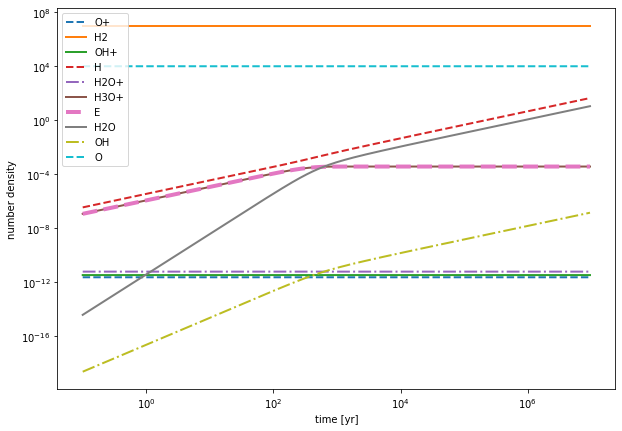

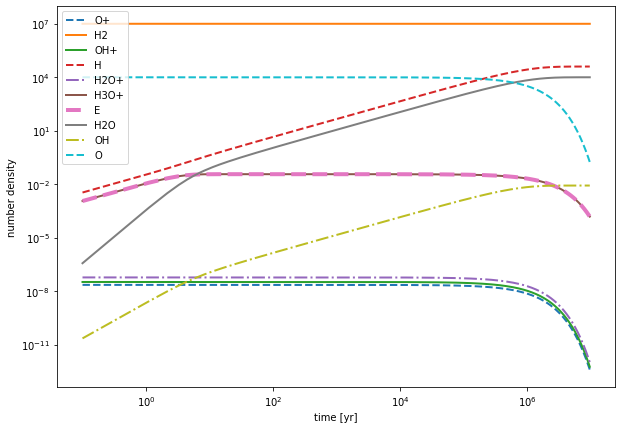

In [362]:
ionizing_cosmic_ray_flux = 1.3e-18
plot(solution(differential_equations))
ionizing_cosmic_ray_flux = 1.3e-14
plot(solution(differential_equations))

time used: 0.10 sec


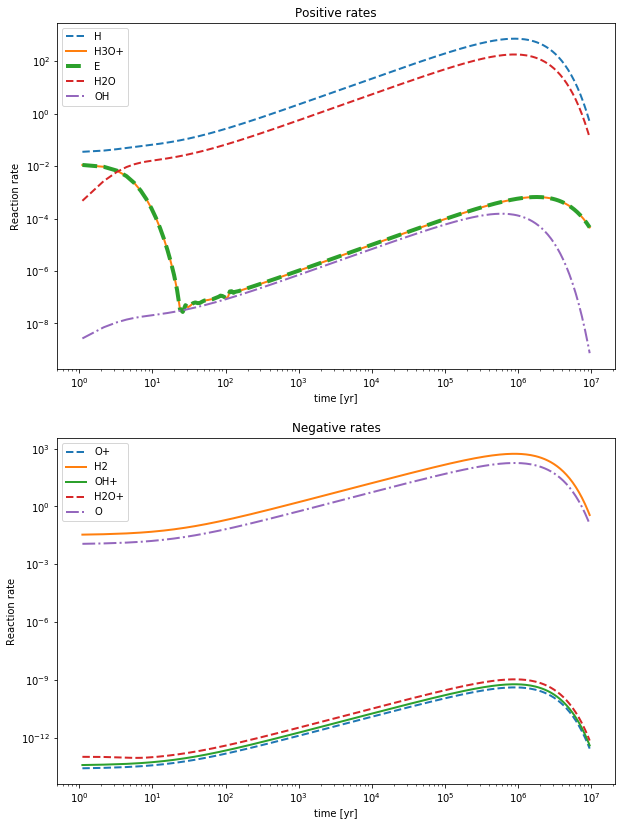

In [364]:
plot_rates(solution(differential_equations))
# note that E/H3O+ isn't right in the last part of the plot

From this we can see that there are two main groups of molecules which go together. 
1. O, O+, OH+, E, H20+, H30+ (where E and H3O+ follow each other). Note that E is above H3O+ since n(E)=sum(n(ions)), but the most abundant ion here is H3O+ by far.
2. OH, H, H2O (These are all the ones that have no outlet, so while the reactants they need to form might not be present, they remain the same, which we see as a flattening of the curve)

Since O is the "beginning" of the reaction chain as described above, as soon as that drops in abundance, having been used up completely by the increased cosmic ray rate, the whole reaction chain goes down, and we see that group 2 flattens out, and group 1 are all quickly depleted since they are deposited in group 2.

## Carbon monoxide (CO)
Carbon monoxide (CO) is arguably, next after H$_2$ and H$_2$O, the most important molecule in the interstellar medium and in protoplanetary disks, both because it affects the abundance of many other molecules, and because it is easily detected, and hence is often used as a proxy to estimate other abundances.   

CO is a strongly bound molecule, which under a broad range of conditions tends to consume most of the available carbon and / or oxygen. Under normal conditions there is more oxygen than carbon (about twice as much), and thus almost all of the carbon ends up in CO and CO consumes a corresponding amount of oxygen.  If, on the other hand, carbon is more abundant than oxygen (basically the definition of 'carbon stars'), then it's the other way around; nearly all oxygen gets locked up into CO. Carbon stars are generally the only place in the universe where refractory carbon (think _wood_) can be made in large quantities. Note that, since oxygen is a crucial element in many other reactions, the ratio C:O is thus a very important abundance parameter!

#### __Task 4: Add Carbon Monoxide (CO) to the reaction network__ (50p)
Your task here is to add species and reactions to the network relevant for CO, and discuss the behavior and influence of this important molecule. 

There are many reactions that influence the amount of CO, and many papers that use various simplified reaction networks. One of them, Nelson and Langer (1997), is available on Absalon as an annotated PDF file, and from that we may adopt these reactions and rates (simplified even somewhat relative to the paper):

In [365]:
#add H+, CO, C, C+, CH2, CH2+
i = {'O+':0,'H2':1 ,'OH+':2, 'H':3, 'H2O+':4 , 'H3O+':5, 'E':6, 'H2O':7 , 'OH':8, 'O':9, 'C':10, 'CO':11, 'C+':12, 'CH2+':13, 'CH2':14, 'H+':15}
N_species = len(i)

In [366]:
number_density = np.zeros(N_species)
n_H2 = 1e7
Tgas = 50
number_density[:      ] = 1e-40
number_density[i['H2']] = n_H2
number_density[i['C' ]] = n_H2*1e-4
number_density[i['O' ]] = n_H2*2e-4

In [367]:
#Added this part
def rate_coefficients():
    invsqrt = 1e0/np.sqrt(Tgas/3e2)
    k = {}
    k['O+   + H2 -> OH+  + H' ] = 1.6e-9
    k['OH+  + H2 -> H2O+ + H' ] = 1.1e-9
    k['H2O+ + H2 -> H3O+ + H' ] = 6.1e-10 
    k['H3O+ + E  -> H2O  + H' ] = 1.1e-7*invsqrt 
    k['H2O+ + E  -> OH   + H' ] = 8.6e-8*invsqrt
    k['H2O+ + E  -> O    + H2'] = 3.9e-8*invsqrt
    k['OH+  + E  -> O    + H' ] = 6.3e-9*(Tgas/3e2)**(-.48)
    k['O    + CR -> O+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux
    # CO reactions and rates used by Nelson & Langer (1977)
    k['CO   + hv -> C    + O' ] = 1e-10*np.exp(-tau_UV)
    k['C    + hv -> C+   + E' ] = 1e-10*np.exp(-tau_UV)
    k['C+   + H2 -> CH2+ + hv'] = 5e-16
    k['CH2+ + E  -> CH2  + hv'] = 1.0e-8*invsqrt
    k['CH2  + hv -> C    + H2'] = 1e-10*np.exp(-tau_UV)
    k['CH2  + O  -> CO   + H2'] = 5e-10
    k['H    + CR -> H+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux #This changes things quite a lot
    return k
k=rate_coefficients()
k

{'O+   + H2 -> OH+  + H': 1.6e-09,
 'OH+  + H2 -> H2O+ + H': 1.1e-09,
 'H2O+ + H2 -> H3O+ + H': 6.1e-10,
 'H3O+ + E  -> H2O  + H': 2.694438717061496e-07,
 'H2O+ + E  -> OH   + H': 2.106561178793533e-07,
 'H2O+ + E  -> O    + H2': 9.553009996854394e-08,
 'OH+  + E  -> O    + H': 1.4888575570590416e-08,
 'O    + CR -> O+   + E': 3.6399999999999995e-14,
 'CO   + hv -> C    + O': 3.678794411714424e-11,
 'C    + hv -> C+   + E': 3.678794411714424e-11,
 'C+   + H2 -> CH2+ + hv': 5e-16,
 'CH2+ + E  -> CH2  + hv': 2.4494897427831778e-08,
 'CH2  + hv -> C    + H2': 3.678794411714424e-11,
 'CH2  + O  -> CO   + H2': 5e-10,
 'H    + CR -> H+   + E': 3.6399999999999995e-14}

In [368]:
def reaction_rates(n):
    k = rate_coefficients()
    return  [k['O+   + H2 -> OH+  + H' ] * n[i['O+'  ]] * n[i['H2']], # 0
             k['OH+  + H2 -> H2O+ + H' ] * n[i['OH+' ]] * n[i['H2']], # 1
             k['H2O+ + H2 -> H3O+ + H' ] * n[i['H2O+']] * n[i['H2']], # 2
             k['H3O+ + E  -> H2O  + H' ] * n[i['H3O+']] * n[i['E' ]], # 3
             k['H2O+ + E  -> OH   + H' ] * n[i['H2O+']] * n[i['E' ]], # 4
             k['H2O+ + E  -> O    + H2'] * n[i['H2O+']] * n[i['E' ]], # 5
             k['OH+  + E  -> O    + H' ] * n[i['OH+' ]] * n[i['E' ]], # 6
             k['O    + CR -> O+   + E' ] * n[i['O'   ]],             # 7
             k['CO   + hv -> C    + O' ] * n[i['CO']],
             k['C    + hv -> C+   + E' ] * n[i['C']],
             k['C+   + H2 -> CH2+ + hv'] * n[i['H2']]* n[i['C+']],
             k['CH2+ + E  -> CH2  + hv'] * n[i['CH2+']]*n[i['E']],
             k['CH2  + hv -> C    + H2'] * n[i['CH2']],
             k['CH2  + O  -> CO   + H2'] *n[i['CH2']]*n[i['O']],
             k['H    + CR -> H+   + E' ] * n[i['H']]]
reaction_rates(number_density)

[1.6e-42,
 1.0999999999999997e-42,
 6.0999999999999996e-43,
 2.694438717061495e-87,
 2.1065611787935326e-87,
 9.553009996854392e-88,
 1.4888575570590414e-88,
 7.279999999999998e-11,
 3.6787944117144236e-51,
 3.678794411714424e-08,
 5e-49,
 2.4494897427831775e-88,
 3.6787944117144236e-51,
 1e-46,
 3.6399999999999994e-54]

In [369]:
def differential_equations(t,n):
    r = reaction_rates(n)
    dn = np.zeros(N_species)
    dn[i['O+'  ]] = -r[0]                              +r[7]
    dn[i['H2'  ]] = -r[0]-r[1]-r[2]          +r[5] -r[10]+r[12]+r[13]
    dn[i['OH+' ]] = +r[0]-r[1]                    -r[6]
    dn[i['H'   ]] = +r[0]+r[1]+r[2]+r[3]+r[4]     +r[6]-r[14]
    dn[i['H2O+']] =      +r[1]-r[2]     -r[4]-r[5]
    dn[i['H3O+']] =           +r[2]-r[3]
    dn[i['E'   ]] =                -r[3]-r[4]-r[5]-r[6]+r[7]+r[9]-r[11]+r[14]
    dn[i['H2O' ]] =                +r[3]
    dn[i['OH'  ]] =                     +r[4]
    dn[i['O'   ]] =                          +r[5]+r[6]-r[7] + r[8]-r[13]
    dn[i['C'   ]] =   +r[8]-r[9] +r[12]
    dn[i['CO'   ]] =  -r[8]+r[13]
    dn[i['C+'   ]] = +r[9] -r[10]
    dn[i['CH2+'   ]] =  +r[10]-r[11]
    dn[i['CH2'   ]] =   r[11] -r[12]-r[13]
    dn[i['H+'   ]] =  r[14] 
    return dn
differential_equations(0.0, number_density)

array([ 7.28000000e-11, -3.30990050e-42,  5.00000000e-43,  3.31000000e-42,
        4.90000000e-43,  6.10000000e-43,  3.68607441e-08,  2.69443872e-87,
        2.10656118e-87, -7.28000000e-11, -3.67879441e-08,  9.99963212e-47,
        3.67879441e-08,  5.00000000e-49, -1.00003679e-46,  3.64000000e-54])

In [370]:
def solution(diff_eqs, yrs=1e7, max_step=1e6, method='LSODA', rtol=1e-6, atol=1e-40):
    spy = 365e0*24e0*3600e0        # seconds per year
    time_step = np.copy(spy)       # initial time-step (s)
    time_end  = yrs*spy            # end of simulation (s)
    n = number_density

    start = tm.time()

    # time_grid is a geometrically increasing series with a max spacing of "max_step" yrs
    time_grid = []
    time      = 0.1 * time_step   # initial time output > 0 to avoid species having 1e-40 number density
    while time < time_end:
        time_grid.append(time)
        time += time_step
        time_step = min(time_step * 1.05, max_step*spy) #one can change this for better resolution if needed

    time_grid = np.array(time_grid)

    # Make sure we are charge neutral. Compute electrons number density (sum over ions)
    n[i['E']] = n[i['O+']] + n[i['OH+']] + n[i['H2O+']] + n[i['H3O+']]+ n[i['C+']]+ n[i['CH2+']]+ n[i['H+']]

    # Solve the differential equations defined in "diff_eqs" over the interval "(0,time_end)"
    # with input values "n" storing the solution at times "time_grid" using the ODE solver
    # method "method" (LSODA) with relative and absolute tolerances "rtol", "atol".
    solution = solve_ivp(diff_eqs, (0, time_end), n, t_eval=time_grid, \
                         method=method, rtol=rtol, atol=atol)
    print('time used: {:.2f} sec'.format(tm.time()-start))

    # return solution times in units of yr and number densities for each time in time_grid.
    return solution.t/spy, solution.y

yr,n = solution(differential_equations)

time used: 0.33 sec


time used: 0.19 sec


(1e-20, 100000000.0)

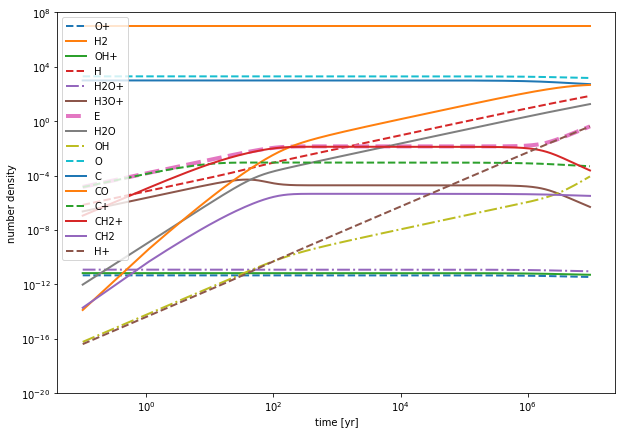

In [376]:
ionizing_cosmic_ray_flux = 1.3e-17
tau_UV=10
result = solution(differential_equations)

plot(result, last=np.shape(result[1])[0])
plt.ylim(1e-20,1e8)

In [ ]:
m

In [337]:
def print_rates(n,t=0.0):
    r = reaction_rates(n)
    eqnh(r)
    dn = np.zeros(N_species)           
    dn[i['O+'  ]] = -r[0]                              +r[7]
    eqnp('O+',[ -1,   0,   0,   0,   0,   0,   0,  1 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['H2'  ]] = -r[0]-r[1]-r[2]          +r[5] -r[10]+r[12]+r[13]
    eqnp('H2',     [ -1,   -1,   -1,   0,   0,   1,   0,  0 , 0,   0,   -1,   0,   1,   1,   0], dn, r, n)
    dn[i['OH+' ]] = +r[0]-r[1]                    -r[6]
    eqnp('OH+', [ 1,   -1,   0,   0,   0,   0,   -1,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['H'   ]] = +r[0]+r[1]+r[2]+r[3]+r[4]     +r[6]-r[14]
    eqnp('H',[ 1,   1,   1,   1,   1,   0,   1,  0 , 0,   0,   0,   0,   0,   0,   -1], dn, r, n)
    dn[i['H2O+']] =      +r[1]-r[2]     -r[4]-r[5]
    eqnp('H2O+',[ 0,   1,   -1,   0,   -1,   -1,   0,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['H3O+']] =           +r[2]-r[3]
    eqnp('H3O+',[ 0,   0,   1,   -1,   0,   0,   0,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['E'   ]] =                -r[3]-r[4]-r[5]-r[6]+r[7]+r[9]-r[11]+r[14]
    eqnp('E',[ 0,   0,   0,   -1,   -1,   -1,   -1,  1 , 0,   1,   0,   -1,   0,   0,   1], dn, r, n)
    dn[i['H2O' ]] =                +r[3]
    eqnp('H2O',[ 0,   0,   0,   1,   0,   0,   0,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['OH'  ]] =                     +r[4]
    eqnp('OH',[ 0,   0,   0,   0,   1,   0,   0,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['O'   ]] =                          +r[5]+r[6]-r[7] + r[8]-r[13]
    eqnp('O',[ 0,   0,   0,   0,   0,   1,   1,  -7 , 1,   0,   0,   0,   0,   -1,   0], dn, r, n)
    dn[i['C'   ]] =   +r[8]-r[9] +r[12]
    eqnp('C',[ 0,   0,   0,   0,   0,   0,   0,  0 , 1,   -1,   0,   0,   1,   0,   0], dn, r, n)
    dn[i['CO'   ]] =  -r[8]+r[13]
    eqnp('CO',[ 0,   0,   0,   0,   0,   0,   0,  0 , -1,   0,   0,   0,   0,   1,   0], dn, r, n)
    dn[i['C+'   ]] = +r[9] -r[10]
    eqnp('C+',[ 0,   0,   0,   0,   0,   0,   0,  0 , 0,   1,   -1,   0,   0,   0,   0], dn, r, n)
    dn[i['CH2+'   ]] =  +r[10]-r[11]
    eqnp('CH2+',[ 0,   0,   0,   0,   0,   0,   0,  0 , 0,   0,   1,   -1,   0,   0,   0], dn, r, n)
    dn[i['CH2'   ]] =   r[11] -r[12]-r[13]
    eqnp('CH2',[ 0,   0,   0,   0,   0,   0,   0,  0 , 0,   0,   0,   1,   -1,   -1,   0], dn, r, n)
    dn[i['H+'   ]] =  r[14] 
    eqnp('H+',[ 0,   0,   0,   0,   0,   0,   0,  0 , 0,   0,   0,   0,   0,   0,   1], dn, r, n)
    rpr(n)
#remember to check the index
print_rates(number_density)

  Eqn:      sum =     r[0]    r[1]    r[2]    r[3]    r[4]    r[5]    r[6]    r[7]    r[8]    r[9]   r[10]   r[11]   r[12]   r[13]   r[14]  relative sum
   O+:  7.3e-14 = -1.6e-42                                                +7.3e-14                                                           7.3e+26
   H2: -3.3e-42 = -1.6e-42-1.1e-42-6.1e-43                +6.7e-87                                -5.0e-49        +9.0e-51+1.0e-46          -3.3e-49
  OH+:  5.0e-43 = +1.6e-42-1.1e-42                                -1.0e-87                                                                   5.0e-03
    H:  3.3e-42 = +1.6e-42+1.1e-42+6.1e-43+1.9e-86+1.5e-86        +1.0e-87                                                        -3.6e-57   3.3e-02
 H2O+:  4.9e-43 =         +1.1e-42-6.1e-43        -1.5e-86-6.7e-87                                                                           4.9e-03
 H3O+:  6.1e-43 =                 +6.1e-43-1.9e-86                                                    

In [402]:
k

{'O+   + H2 -> OH+  + H': 1.6e-09,
 'OH+  + H2 -> H2O+ + H': 1.1e-09,
 'H2O+ + H2 -> H3O+ + H': 6.1e-10,
 'H3O+ + E  -> H2O  + H': 2.694438717061496e-07,
 'H2O+ + E  -> OH   + H': 2.106561178793533e-07,
 'H2O+ + E  -> O    + H2': 9.553009996854394e-08,
 'OH+  + E  -> O    + H': 1.4888575570590416e-08,
 'O    + CR -> O+   + E': 3.6399999999999995e-14,
 'CO   + hv -> C    + O': 3.678794411714424e-11,
 'C    + hv -> C+   + E': 3.678794411714424e-11,
 'C+   + H2 -> CH2+ + hv': 5e-16,
 'CH2+ + E  -> CH2  + hv': 2.4494897427831778e-08,
 'CH2  + hv -> C    + H2': 3.678794411714424e-11,
 'CH2  + O  -> CO   + H2': 5e-10,
 'H    + CR -> H+   + E': 3.6399999999999995e-14}

To implement, you should
   1. Consider which extra species you need to add
   2. Add the reactions listed above to the coefficents and rates functions
   3. Add the extra equations needed to follow the evolution of the extra species, and add the new rates to these and to those existing equations that are also affected
   4. Optionally, fill in a scheme such as the one above, so you can see the importance of the different reaction channels

You can then discuss how CO behaves and influences the rest of the network. _Suggestions_ for what to look at are

   5. How fast is CO formed; how does it change the oxygen reservoir, and what other species starts to dominate at the end of the evolution 
   6. How does the value of `tau_UV` affect the network (what is tau_UV; try changing it)? What about the initial mix of C and O?
   7. (Bonus task) What reactions are the bottlenecks for the creation of CO?

Notice that because we add C to the network, we need a new initial condition, and with a more complete network we can assume a lower and more realistic abundance for O. The following block of code is a *suggestion* and can be executed once you have defined an updated list of species

### Plot the results that correspond to the original case
HINT:  You can compare side-by-side, by right-clicking on the tab and choose "New view for Notebook"-

time used: 0.17 sec


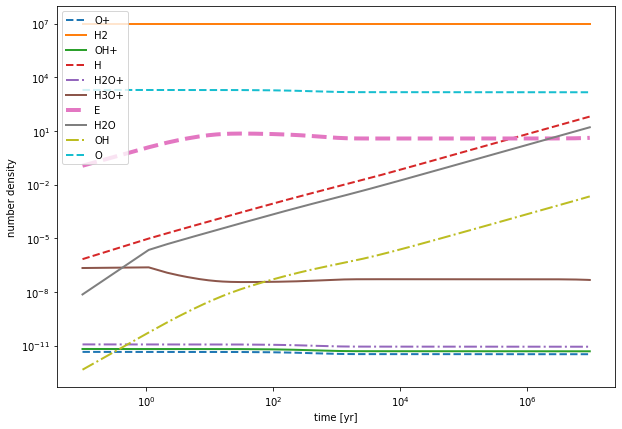

In [340]:
ionizing_cosmic_ray_flux = 1.3e-17
tau_UV=1
result = solution(differential_equations)
N_first = 10
plot(result,last=N_first,linewidth=2)

### Plot the results that pertain to CO

n(C) : 498.0786236141249
n(CO): 498.05395795623554


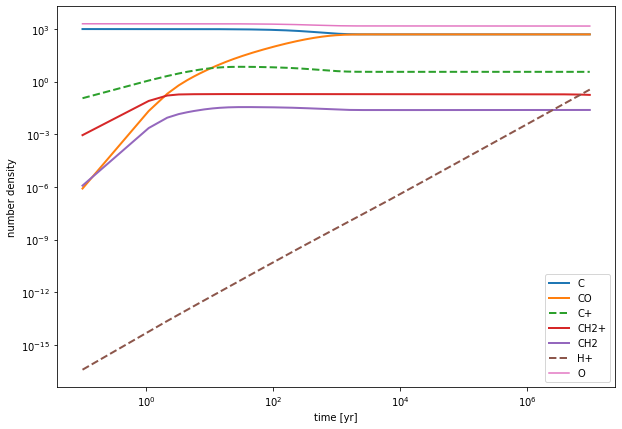

In [341]:
plot(result,N_first,N_species)
yr = result[0]; n=result[1]
plt.plot(yr,n[i['O']],label='O'); plt.legend();
print("n(C) :",n[i['C']][-1])
print("n(CO):",n[i['CO']][-1])

# __Absalon turn-in:__

Please answer the tasks, and add updated code below this line together with your discussion, and supporting plots. Upload as notebook and as pdf together with your sketch of the network.

## Task 1

I have drawn the reaction network with H2, H, and E as "enablers"/"catalysts". Here we easily see which reaction have no drain and thus will either accumulate or stay constant at any time.

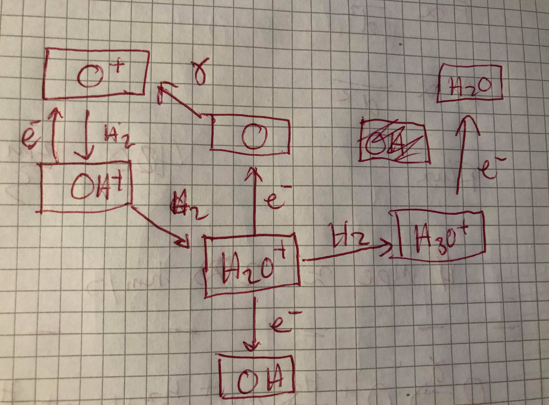


## Task 2: Answer

First of all, there are some things that do not change that much, since their abundances are very high, and their reaction rates aren't high enough enough for them to change on the timescale we investigate here. For this first case I am specifically thinking about $H_2$ and $O$. The only reaction that removes $O$ is 7 and the cosmic ray ionization rate of 1.3e-17 is just not high enough to really make anything happen, as can be seen in my relative sum extension to Troels' function below.

Three types don't have an outlet, H, H2O, OH, so they then increase continuosly. They have the exact same relative growth rates in the end since all things they depend on are stable and their "equilibrium" is just stable growth.

H has no reaction that uses it, so it is continually produced. If we let this continue, we could reach a point where all hydrogen in the system is in atomic form. Note that all reaction rates are positive as can be seen in the above plot.

Looking at the reaction rates, we can see that the reaction chain essentially goes quickly through 7->0->1->2, which means that O+, OH+ and H2O+ are used almost as soon as they are produced, which we see as them being in equilibrium at a very low abundance throughout everything. This holds as long as H2 (the "catalysator" for 0,1,2) and O (for 7) abundances remain high. 3 is then a bottleneck since it is much slower than the former. Thus, E and H30+, the reactants in 3, are not used very quickly, and grow together. However, they eventually reach the same reaction rate as 0,1,2 and is thus a quick reaction and no longer a bottleneck. These two are now in equlibrium. Since these two keep growing, and these two together make H2O, the growth rate of H2O is higher than the equilibrium growth rate which we see later. 

E and H3O+ grow together, since H3O+ is by far the highest abundance atom, and our mixture is electrically neutral by construction.

At least, I want to make a remark on the notion than some of the abundances stop changing. They don't, simply just much slower than before as can be seen in the rate plot above.

## Task 3

time used: 0.05 sec
time used: 0.10 sec


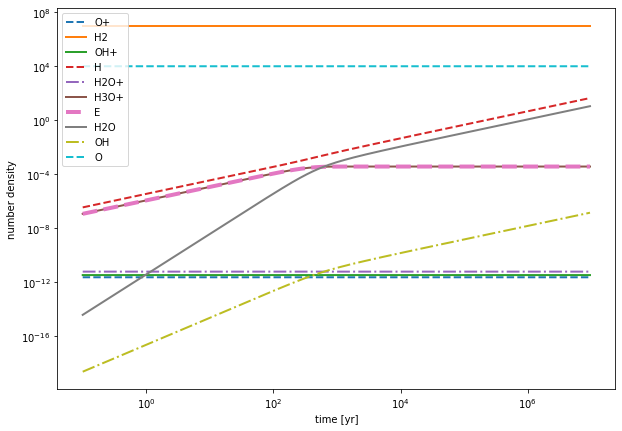

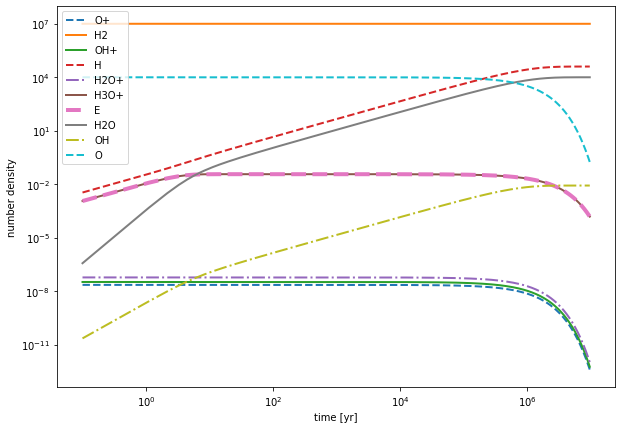

In [362]:
ionizing_cosmic_ray_flux = 1.3e-18
plot(solution(differential_equations))
ionizing_cosmic_ray_flux = 1.3e-14
plot(solution(differential_equations))

time used: 0.10 sec


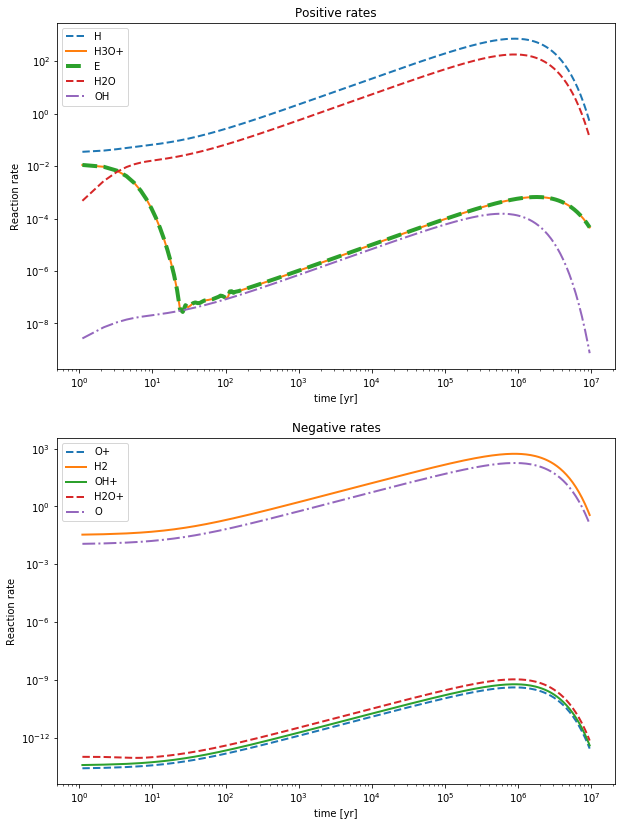

In [364]:
plot_rates(solution(differential_equations))
# note that E/H3O+ isn't right in the last part of the plot

From this we can see that there are two main groups of molecules which go together. 
1. O, O+, OH+, E, H20+, H30+ (where E and H3O+ follow each other). Note that E is above H3O+ since n(E)=sum(n(ions)), but the most abundant ion here is H3O+ by far.
2. OH, H, H2O (These are all the ones that have no outlet, so while the reactants they need to form might not be present, they remain the same, which we see as a flattening of the curve)

Since O is the "beginning" of the reaction chain as described above, as soon as that drops in abundance, having been used up completely by the increased cosmic ray rate, the whole reaction chain goes down, and we see that group 2 flattens out, and group 1 are all quickly depleted since they are deposited in group 2.

## Task 4: New code

In [409]:
#add H+, CO, C, C+, CH2, CH2+
i = {'O+':0,'H2':1 ,'OH+':2, 'H':3, 'H2O+':4 , 'H3O+':5, 'E':6, 'H2O':7 , 'OH':8, 'O':9, 'C':10, 'CO':11, 'C+':12, 'CH2+':13, 'CH2':14, 'H+':15}
N_species = len(i)

In [410]:
#Added this part
def rate_coefficients():
    invsqrt = 1e0/np.sqrt(Tgas/3e2)
    k = {}
    k['O+   + H2 -> OH+  + H' ] = 1.6e-9
    k['OH+  + H2 -> H2O+ + H' ] = 1.1e-9
    k['H2O+ + H2 -> H3O+ + H' ] = 6.1e-10 
    k['H3O+ + E  -> H2O  + H' ] = 1.1e-7*invsqrt 
    k['H2O+ + E  -> OH   + H' ] = 8.6e-8*invsqrt
    k['H2O+ + E  -> O    + H2'] = 3.9e-8*invsqrt
    k['OH+  + E  -> O    + H' ] = 6.3e-9*(Tgas/3e2)**(-.48)
    k['O    + CR -> O+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux
    # CO reactions and rates used by Nelson & Langer (1977)
    k['CO   + hv -> C    + O' ] = 1e-10*np.exp(-tau_UV)
    k['C    + hv -> C+   + E' ] = 1e-10*np.exp(-tau_UV)
    k['C+   + H2 -> CH2+ + hv'] = 5e-16
    k['CH2+ + E  -> CH2  + hv'] = 1.0e-8*invsqrt
    k['CH2  + hv -> C    + H2'] = 1e-10*np.exp(-tau_UV)
    k['CH2  + O  -> CO   + H2'] = 5e-10
    k['H    + CR -> H+   + E' ] = 2.8e0*ionizing_cosmic_ray_flux #This changes things quite a lot
    return k
k=rate_coefficients()
k

{'O+   + H2 -> OH+  + H': 1.6e-09,
 'OH+  + H2 -> H2O+ + H': 1.1e-09,
 'H2O+ + H2 -> H3O+ + H': 6.1e-10,
 'H3O+ + E  -> H2O  + H': 2.694438717061496e-07,
 'H2O+ + E  -> OH   + H': 2.106561178793533e-07,
 'H2O+ + E  -> O    + H2': 9.553009996854394e-08,
 'OH+  + E  -> O    + H': 1.4888575570590416e-08,
 'O    + CR -> O+   + E': 3.64e-17,
 'CO   + hv -> C    + O': 3.678794411714424e-11,
 'C    + hv -> C+   + E': 3.678794411714424e-11,
 'C+   + H2 -> CH2+ + hv': 5e-16,
 'CH2+ + E  -> CH2  + hv': 2.4494897427831778e-08,
 'CH2  + hv -> C    + H2': 3.678794411714424e-11,
 'CH2  + O  -> CO   + H2': 5e-10,
 'H    + CR -> H+   + E': 3.64e-17}

In [411]:
def reaction_rates(n):
    k = rate_coefficients()
    return  [k['O+   + H2 -> OH+  + H' ] * n[i['O+'  ]] * n[i['H2']], # 0
             k['OH+  + H2 -> H2O+ + H' ] * n[i['OH+' ]] * n[i['H2']], # 1
             k['H2O+ + H2 -> H3O+ + H' ] * n[i['H2O+']] * n[i['H2']], # 2
             k['H3O+ + E  -> H2O  + H' ] * n[i['H3O+']] * n[i['E' ]], # 3
             k['H2O+ + E  -> OH   + H' ] * n[i['H2O+']] * n[i['E' ]], # 4
             k['H2O+ + E  -> O    + H2'] * n[i['H2O+']] * n[i['E' ]], # 5
             k['OH+  + E  -> O    + H' ] * n[i['OH+' ]] * n[i['E' ]], # 6
             k['O    + CR -> O+   + E' ] * n[i['O'   ]],             # 7
             k['CO   + hv -> C    + O' ] * n[i['CO']],
             k['C    + hv -> C+   + E' ] * n[i['C']],
             k['C+   + H2 -> CH2+ + hv'] * n[i['H2']]* n[i['C+']],
             k['CH2+ + E  -> CH2  + hv'] * n[i['CH2+']]*n[i['E']],
             k['CH2  + hv -> C    + H2'] * n[i['CH2']],
             k['CH2  + O  -> CO   + H2'] *n[i['CH2']]*n[i['O']],
             k['H    + CR -> H+   + E' ] * n[i['H']]]
reaction_rates(number_density)

[1.6e-42,
 1.0999999999999997e-42,
 6.0999999999999996e-43,
 1.8861071019430466e-86,
 1.4745928251554728e-86,
 6.687106997798075e-87,
 1.0422002899413291e-87,
 7.279999999999999e-14,
 3.6787944117144236e-51,
 3.678794411714424e-08,
 5e-49,
 1.7146428199482242e-87,
 3.6787944117144236e-51,
 1e-46,
 3.6399999999999995e-57]

In [412]:
def differential_equations(t,n):
    r = reaction_rates(n)
    dn = np.zeros(N_species)
    dn[i['O+'  ]] = -r[0]                              +r[7]
    dn[i['H2'  ]] = -r[0]-r[1]-r[2]          +r[5] -r[10]+r[12]+r[13]
    dn[i['OH+' ]] = +r[0]-r[1]                    -r[6]
    dn[i['H'   ]] = +r[0]+r[1]+r[2]+r[3]+r[4]     +r[6]-r[14]
    dn[i['H2O+']] =      +r[1]-r[2]     -r[4]-r[5]
    dn[i['H3O+']] =           +r[2]-r[3]
    dn[i['E'   ]] =                -r[3]-r[4]-r[5]-r[6]+r[7]+r[9]-r[11]+r[14]
    dn[i['H2O' ]] =                +r[3]
    dn[i['OH'  ]] =                     +r[4]
    dn[i['O'   ]] =                          +r[5]+r[6]-r[7] + r[8]-r[13]
    dn[i['C'   ]] =   +r[8]-r[9] +r[12]
    dn[i['CO'   ]] =  -r[8]+r[13]
    dn[i['C+'   ]] = +r[9] -r[10]
    dn[i['CH2+'   ]] =  +r[10]-r[11]
    dn[i['CH2'   ]] =   r[11] -r[12]-r[13]
    dn[i['H+'   ]] =  r[14] 
    return dn
differential_equations(0.0, number_density)

array([ 7.28000000e-14, -3.30990050e-42,  5.00000000e-43,  3.31000000e-42,
        4.90000000e-43,  6.10000000e-43,  3.67880169e-08,  1.88610710e-86,
        1.47459283e-86, -7.28000000e-14, -3.67879441e-08,  9.99963212e-47,
        3.67879441e-08,  5.00000000e-49, -1.00003679e-46,  3.64000000e-57])

In [413]:
def solution(diff_eqs, yrs=1e7, max_step=1e6, method='LSODA', rtol=1e-6, atol=1e-40):
    spy = 365e0*24e0*3600e0        # seconds per year
    time_step = np.copy(spy)       # initial time-step (s)
    time_end  = yrs*spy            # end of simulation (s)
    n = number_density

    start = tm.time()

    # time_grid is a geometrically increasing series with a max spacing of "max_step" yrs
    time_grid = []
    time      = 0.1 * time_step   # initial time output > 0 to avoid species having 1e-40 number density
    while time < time_end:
        time_grid.append(time)
        time += time_step
        time_step = min(time_step * 1.05, max_step*spy) #one can change this for better resolution if needed

    time_grid = np.array(time_grid)

    # Make sure we are charge neutral. Compute electrons number density (sum over ions)
    n[i['E']] = n[i['O+']] + n[i['OH+']] + n[i['H2O+']] + n[i['H3O+']]+ n[i['C+']]+ n[i['CH2+']]+ n[i['H+']]

    # Solve the differential equations defined in "diff_eqs" over the interval "(0,time_end)"
    # with input values "n" storing the solution at times "time_grid" using the ODE solver
    # method "method" (LSODA) with relative and absolute tolerances "rtol", "atol".
    solution = solve_ivp(diff_eqs, (0, time_end), n, t_eval=time_grid, \
                         method=method, rtol=rtol, atol=atol)
    print('time used: {:.2f} sec'.format(tm.time()-start))

    # return solution times in units of yr and number densities for each time in time_grid.
    return solution.t/spy, solution.y

yr,n = solution(differential_equations)

time used: 0.16 sec


In [415]:
def print_rates(n,t=0.0):
    r = reaction_rates(n)
    eqnh(r)
    dn = np.zeros(N_species)           
    dn[i['O+'  ]] = -r[0]                              +r[7]
    eqnp('O+',[ -1,   0,   0,   0,   0,   0,   0,  1 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['H2'  ]] = -r[0]-r[1]-r[2]          +r[5] -r[10]+r[12]+r[13]
    eqnp('H2',     [ -1,   -1,   -1,   0,   0,   1,   0,  0 , 0,   0,   -1,   0,   1,   1,   0], dn, r, n)
    dn[i['OH+' ]] = +r[0]-r[1]                    -r[6]
    eqnp('OH+', [ 1,   -1,   0,   0,   0,   0,   -1,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['H'   ]] = +r[0]+r[1]+r[2]+r[3]+r[4]     +r[6]-r[14]
    eqnp('H',[ 1,   1,   1,   1,   1,   0,   1,  0 , 0,   0,   0,   0,   0,   0,   -1], dn, r, n)
    dn[i['H2O+']] =      +r[1]-r[2]     -r[4]-r[5]
    eqnp('H2O+',[ 0,   1,   -1,   0,   -1,   -1,   0,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['H3O+']] =           +r[2]-r[3]
    eqnp('H3O+',[ 0,   0,   1,   -1,   0,   0,   0,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['E'   ]] =                -r[3]-r[4]-r[5]-r[6]+r[7]+r[9]-r[11]+r[14]
    eqnp('E',[ 0,   0,   0,   -1,   -1,   -1,   -1,  1 , 0,   1,   0,   -1,   0,   0,   1], dn, r, n)
    dn[i['H2O' ]] =                +r[3]
    eqnp('H2O',[ 0,   0,   0,   1,   0,   0,   0,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['OH'  ]] =                     +r[4]
    eqnp('OH',[ 0,   0,   0,   0,   1,   0,   0,  0 , 0,   0,   0,   0,   0,   0,   0], dn, r, n)
    dn[i['O'   ]] =                          +r[5]+r[6]-r[7] + r[8]-r[13]
    eqnp('O',[ 0,   0,   0,   0,   0,   1,   1,  -7 , 1,   0,   0,   0,   0,   -1,   0], dn, r, n)
    dn[i['C'   ]] =   +r[8]-r[9] +r[12]
    eqnp('C',[ 0,   0,   0,   0,   0,   0,   0,  0 , 1,   -1,   0,   0,   1,   0,   0], dn, r, n)
    dn[i['CO'   ]] =  -r[8]+r[13]
    eqnp('CO',[ 0,   0,   0,   0,   0,   0,   0,  0 , -1,   0,   0,   0,   0,   1,   0], dn, r, n)
    dn[i['C+'   ]] = +r[9] -r[10]
    eqnp('C+',[ 0,   0,   0,   0,   0,   0,   0,  0 , 0,   1,   -1,   0,   0,   0,   0], dn, r, n)
    dn[i['CH2+'   ]] =  +r[10]-r[11]
    eqnp('CH2+',[ 0,   0,   0,   0,   0,   0,   0,  0 , 0,   0,   1,   -1,   0,   0,   0], dn, r, n)
    dn[i['CH2'   ]] =   r[11] -r[12]-r[13]
    eqnp('CH2',[ 0,   0,   0,   0,   0,   0,   0,  0 , 0,   0,   0,   1,   -1,   -1,   0], dn, r, n)
    dn[i['H+'   ]] =  r[14] 
    eqnp('H+',[ 0,   0,   0,   0,   0,   0,   0,  0 , 0,   0,   0,   0,   0,   0,   1], dn, r, n)
    rpr(n)
#remember to check the index
print_rates(number_density)

  Eqn:      sum =     r[0]    r[1]    r[2]    r[3]    r[4]    r[5]    r[6]    r[7]    r[8]    r[9]   r[10]   r[11]   r[12]   r[13]   r[14]  relative sum
   O+:  7.3e-14 = -1.6e-42                                                +7.3e-14                                                           7.3e+26
   H2: -3.3e-42 = -1.6e-42-1.1e-42-6.1e-43                +6.7e-87                                -5.0e-49        +3.7e-51+1.0e-46          -3.3e-49
  OH+:  5.0e-43 = +1.6e-42-1.1e-42                                -1.0e-87                                                                   5.0e-03
    H:  3.3e-42 = +1.6e-42+1.1e-42+6.1e-43+1.9e-86+1.5e-86        +1.0e-87                                                        -3.6e-57   3.3e-02
 H2O+:  4.9e-43 =         +1.1e-42-6.1e-43        -1.5e-86-6.7e-87                                                                           4.9e-03
 H3O+:  6.1e-43 =                 +6.1e-43-1.9e-86                                                    

## Task 4: Discussion

We see here that H+, which now is the only thing that doesn't have any reaction that uses it up. Thus is increases at a constant rate. This is of course dependent on there being a lot of H, but for our time-scale, there is more than enough.

We also see that CO and C rather quickly reach an equlibrium, and here the reaction rates that disocciates CO and produces C and the one combining CH2 and O to create CO have balanced. This uses up a good part of the O, but not enough to make a really sizeable difference. 

tau_UV is the optical depth at UV wavelengths and is responsible for the reaction speed of the following three reaction:

CO   + hv -> C    + O,  C    + hv -> C+   + E, CH2  + hv -> C    + H2.

Thus, getting an equlibrium with CO is defined hugely by tau_UV.

For the bonus task:

The way CO is created is through the 9->10->11->13 chain, of which reaction 10 has by far the lowest reaction rate. However, this only really becomes important in the late stage as can be seen below.
Until then it is actually the creation of C+ that is the bottleneck step as can be seen by C+ and CO rates being almost exactly mirrored in the beginning. So the answer to this question is that it depends on what stage you're talking about.

## Supporting plots.

In [404]:
number_density = np.zeros(N_species)
n_H2 = 1e7
Tgas = 50
number_density[:      ] = 1e-40
number_density[i['H2']] = n_H2
number_density[i['C' ]] = n_H2*1e-4
number_density[i['O' ]] = n_H2*2e-4

time used: 0.16 sec


(1e-20, 100000000.0)

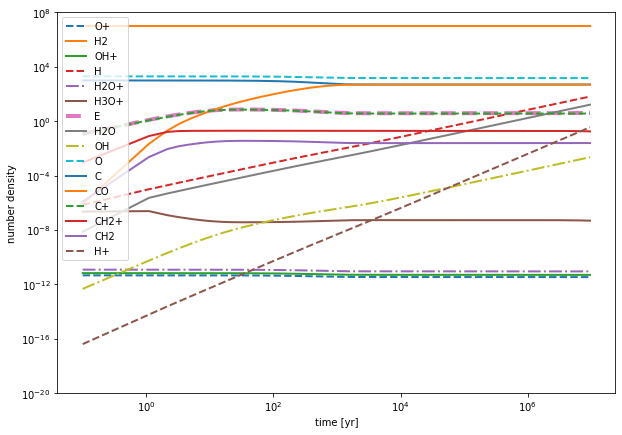

In [405]:
ionizing_cosmic_ray_flux = 1.3e-17
tau_UV=1
result = solution(differential_equations)
plot(result, last=np.shape(result[1])[0])
plt.ylim(1e-20,1e8)

time used: 0.17 sec


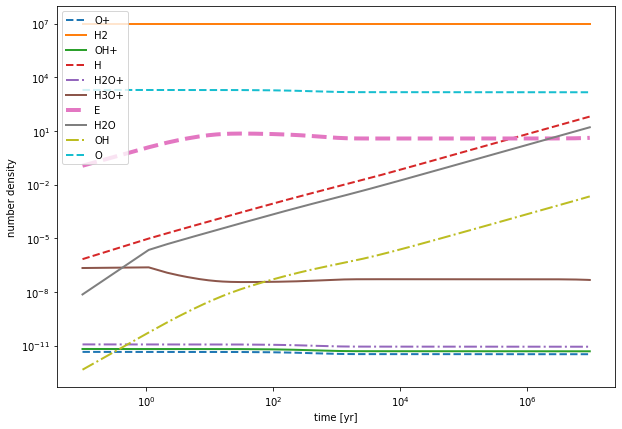

In [406]:
ionizing_cosmic_ray_flux = 1.3e-17
tau_UV=1
result = solution(differential_equations)
N_first = 10
plot(result,last=N_first,linewidth=2)

n(C) : 498.0786236141249
n(CO): 498.05395795623554


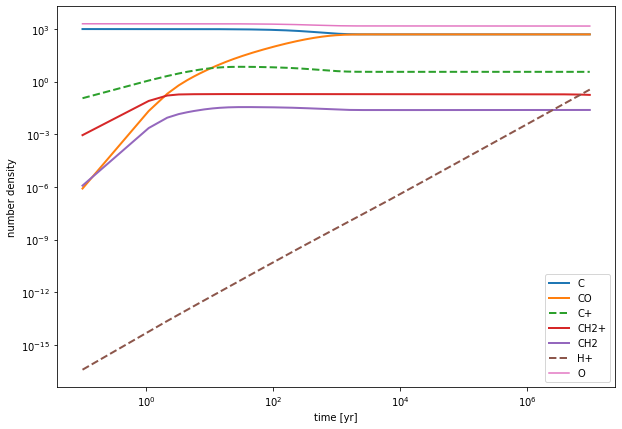

In [407]:
plot(result,N_first,N_species)
yr = result[0]; n=result[1]
plt.plot(yr,n[i['O']],label='O'); plt.legend();
print("n(C) :",n[i['C']][-1])
print("n(CO):",n[i['CO']][-1])

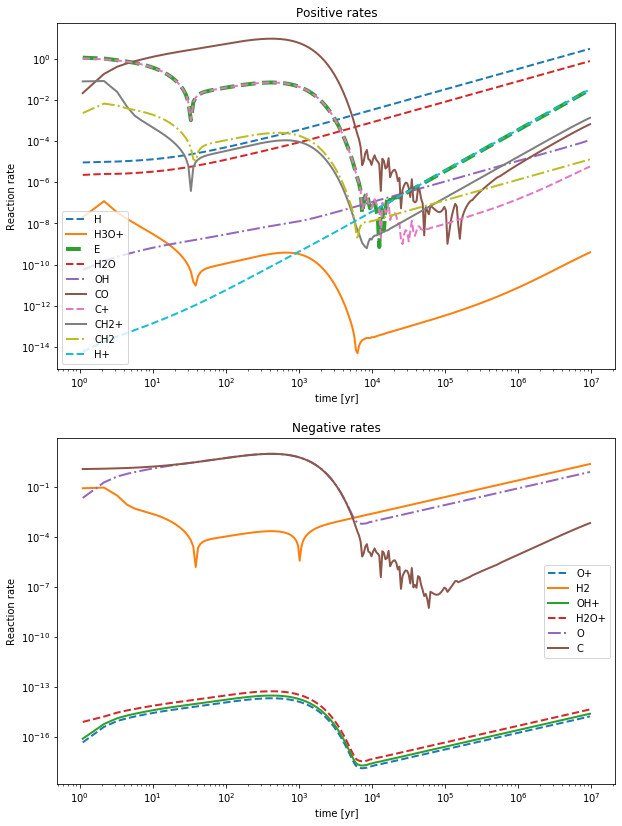

In [408]:
plot_rates(result)

### Changing the CR flux

In [399]:
number_density = np.zeros(N_species)
n_H2 = 1e7
Tgas = 50
number_density[:      ] = 1e-40
number_density[i['H2']] = n_H2
number_density[i['C' ]] = n_H2*1e-4
number_density[i['O' ]] = n_H2*2e-4

time used: 0.36 sec


(1e-20, 100000000.0)

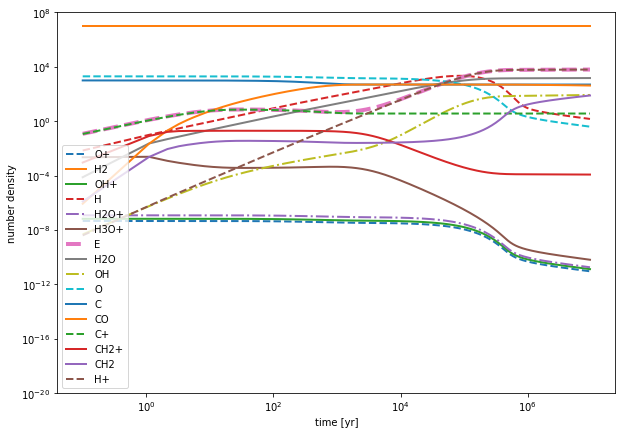

In [400]:
ionizing_cosmic_ray_flux = 1.3e-13
tau_UV=1
result = solution(differential_equations)
plot(result, last=np.shape(result[1])[0])
plt.ylim(1e-20,1e8)

n(C) : 498.1664137908728
n(CO): 420.28992276362686


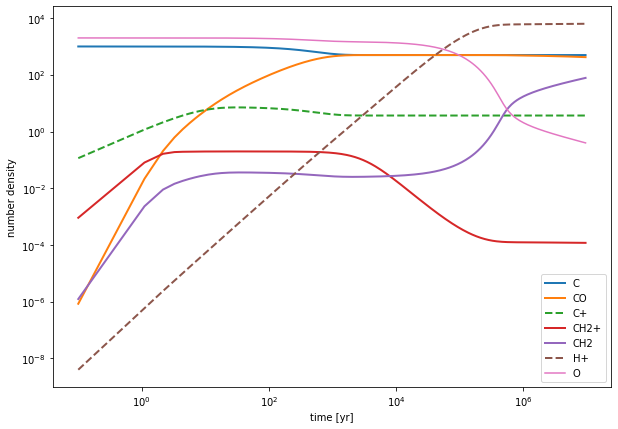

In [401]:
plot(result,N_first,N_species)
yr = result[0]; n=result[1]
plt.plot(yr,n[i['O']],label='O'); plt.legend();
print("n(C) :",n[i['C']][-1])
print("n(CO):",n[i['CO']][-1])

Here we see that the last process is very strongly affected by higher Cosmic Ray Flux, and that O is once again completely depleted, which then again makes CO decrease because there is no flow in due to the lack of O.

### Changing the abundances

In [393]:
number_density = np.zeros(N_species)
n_H2 = 1e7
Tgas = 50
number_density[:      ] = 1e-40
number_density[i['H2']] = n_H2
number_density[i['C' ]] = n_H2*3e-3
number_density[i['O' ]] = n_H2*2e-4

time used: 0.31 sec


(1e-20, 100000000.0)

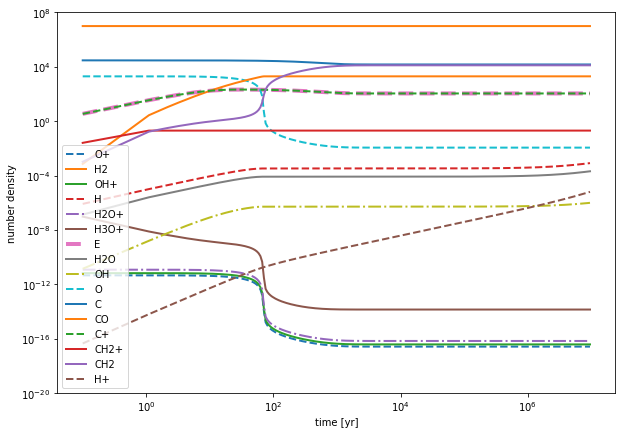

In [394]:
ionizing_cosmic_ray_flux = 1.3e-17
tau_UV=1
result = solution(differential_equations)
plot(result, last=np.shape(result[1])[0])
plt.ylim(1e-20,1e8)

n(C) : 14944.847971935304
n(CO): 1999.9884250350478


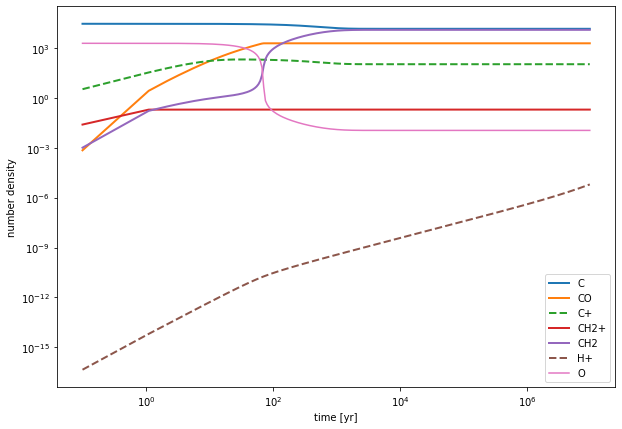

In [395]:
plot(result,N_first,N_species)
yr = result[0]; n=result[1]
plt.plot(yr,n[i['O']],label='O'); plt.legend();
print("n(C) :",n[i['C']][-1])
print("n(CO):",n[i['CO']][-1])

Here we see that the C mainly ends up in CH2, essentially because there is more H2 than O, even though CO forms more rapidly than CH2.